In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from IPython.lib.pretty import datetime
import torch.optim.lr_scheduler as lr_scheduler

Loading MNIST dataset

In [ ]:
import torchvision.transforms as transforms
import torchvision

# Download the training dataset
train_transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)

# Download the testing dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=train_transforms, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 71714408.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56738029.89it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40632954.55it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10393087.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



5

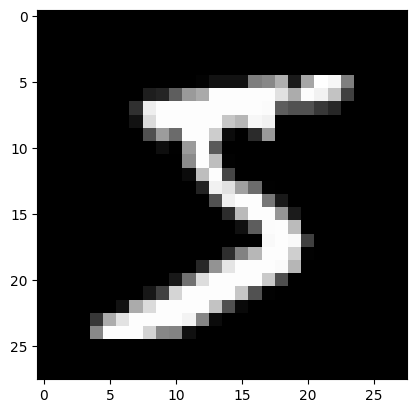

In [ ]:
plt.imshow(train_dataset.data[0], cmap='gray')
train_dataset.targets[0].item()

# 2. Visualizing the MNIST Dataset

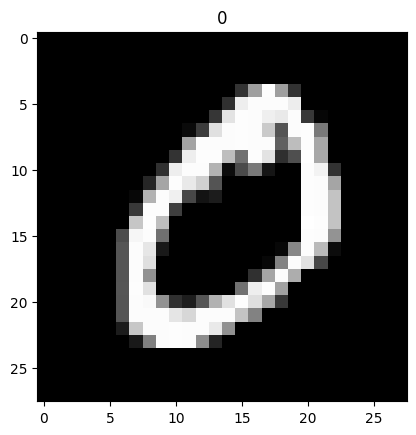

In [ ]:
def visualize_number(input_number):
  plt.imshow(train_dataset.data[input_number], cmap='gray')
  plt.title(train_dataset.targets[input_number].item())



visualize_number(1)

# 3. Implement and Train an MLP Autoencoder

In [ ]:
class autoencoderMLP4Layer(nn.Module):

  def __init__(self, N_inputs=784, N_bottleneck=8, N_outputs=784):
    super(autoencoderMLP4Layer, self).__init__()
    N2 = 392
    self.fc1 = nn.Linear(N_inputs, N2)
    self.fc2 = nn.Linear(N2, N_bottleneck)
    self.fc3 = nn.Linear(N_bottleneck, N2)
    self.fc4 = nn.Linear(N2, N_outputs)
    self.type = 'MLP4'
    self.input_shape = (1, 28*28)

  def forward(self, X):
    # ENCODER
    X = self.fc1(X)
    X = F.relu(X)
    X = self.fc2(X)
    X = F.relu(X)

    # DECODER
    X = self.fc3(X)
    X = F.relu(X)
    X = self.fc4(X)
    X = torch.sigmoid(X)

    return X

  def encode(self, X):
    # ENCODER
    X = self.fc1(X)
    X = F.relu(X)
    X = self.fc2(X)
    X = F.relu(X)

    return X

  def decode(self, X):
    # DECODER
    X = self.fc3(X)
    X = F.relu(X)
    X = self.fc4(X)
    X = torch.sigmoid(X)

    return X

model = autoencoderMLP4Layer()

Converting the flat images (784) to images

In [ ]:
def make_28_by_28(flat_input):
  res = []
  for i in range(28):
    row = []
    for j in range(28):
      row.append(flat_input[j].item())
    res.append(row)
  return res

Model Summary

In [ ]:
from torchsummary import summary

summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 392]         307,720
            Linear-2                 [-1, 1, 8]           3,144
            Linear-3               [-1, 1, 392]           3,528
            Linear-4               [-1, 1, 784]         308,112
Total params: 622,504
Trainable params: 622,504
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.37
Estimated Total Size (MB): 2.39
----------------------------------------------------------------


# Train the Model

In [ ]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, scheduler, device):

  print('Training ...')
  model.train()
  losses_train = []
  num_batches = len(train_loader)

  for epoch in range(n_epochs):
    print('epoch ', epoch+1)
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      flat_input = imgs.view(-1, 1, 28 * 28).to(dtype=torch.float32)
      outputs = model(flat_input)
      optimizer.zero_grad()
      loss = loss_fn(outputs, flat_input)
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    scheduler.step(loss_train)

    # Calculate the average loss for this epoch
    avg_loss_train = loss_train / num_batches
    losses_train.append(avg_loss_train)

     # Print optimizer's state
    for group in optimizer.param_groups:
      print(f"Learning Rate: {group['lr']}")


    print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch+1, avg_loss_train))
  return losses_train


Specify the device type

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')  # Use the first GPU
    print(torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device('cpu')
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


Load data in the DataLoader

In [ ]:
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([1024, 1, 28, 28]) torch.Size([1024])


Train the Model and Save the weights to 'model.pth'

In [ ]:
n_epochs = 50
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

losses_train = train(n_epochs, optimizer, model, loss_fn, train_loader, scheduler, device)

# Save the model
torch.save(model,'model.pth')

Training ...
epoch  1
Learning Rate: 0.001
2023-09-20 17:51:12.175799 Epoch 1, Training loss 0.08599462353829611
epoch  2
Learning Rate: 0.001
2023-09-20 17:51:28.710188 Epoch 2, Training loss 0.05281822231866545
epoch  3
Learning Rate: 0.001
2023-09-20 17:51:41.079082 Epoch 3, Training loss 0.04347676676461252
epoch  4
Learning Rate: 0.001
2023-09-20 17:51:56.628922 Epoch 4, Training loss 0.038173081258596
epoch  5
Learning Rate: 0.001
2023-09-20 17:52:08.638418 Epoch 5, Training loss 0.035804910111730384
epoch  6
Learning Rate: 0.001
2023-09-20 17:52:22.510223 Epoch 6, Training loss 0.03441573351116504
epoch  7
Learning Rate: 0.001
2023-09-20 17:52:35.797065 Epoch 7, Training loss 0.03344992188326383
epoch  8
Learning Rate: 0.001
2023-09-20 17:52:49.208113 Epoch 8, Training loss 0.03270939383971489
epoch  9
Learning Rate: 0.001
2023-09-20 17:53:06.796215 Epoch 9, Training loss 0.03214249033796585
epoch  10
Learning Rate: 0.001
2023-09-20 17:53:20.356612 Epoch 10, Training loss 0.0316

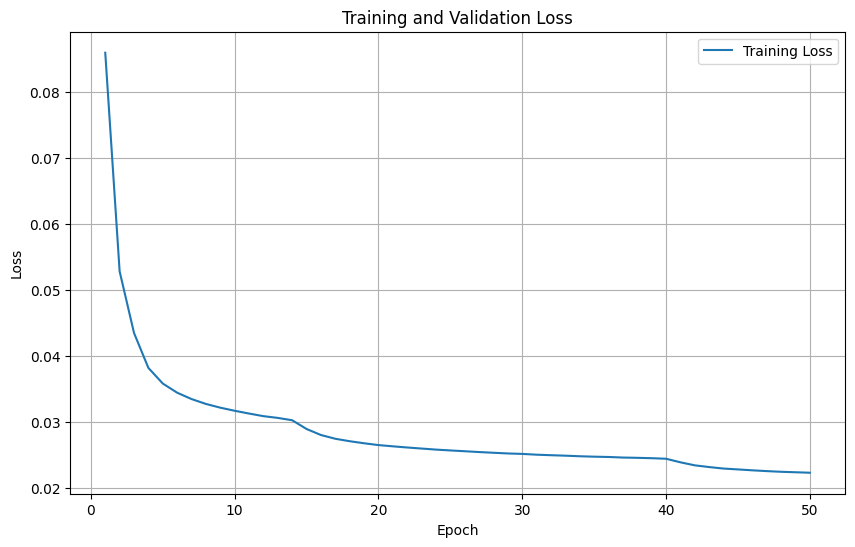

In [ ]:
epochs = range(1, len(losses_train) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_train, label='Training Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Load the model

In [ ]:
# Load the model
model = torch.load('/content/model.pth')

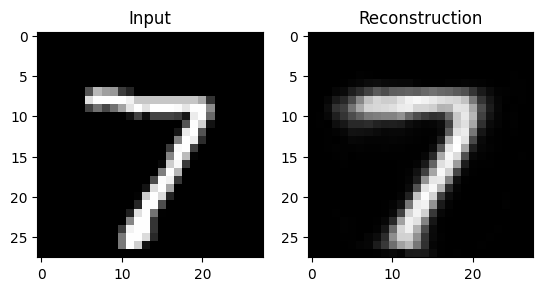

In [ ]:
def visualize_number_reconstruction(input_image, model):
  model.eval()

  flat_input = input_image.view(1, 1, -1).to(dtype=torch.float32)

  # Pass the input through the model to get the output
  with torch.no_grad():  # Use no_grad to disable gradient computation for inference
      res = model(flat_input)

  # Assuming res is a 1D tensor with 784 elements
  res = res.view(1, 28, 28)  # Reshape to a 28x28 tensor
  res_img = res.cpu().numpy()

  fig = plt.figure()
  ax1 = plt.subplot(121)
  plt.imshow(input_tensor, cmap='gray')
  ax1.set_title('Input')
  ax2 = plt.subplot(122)
  plt.imshow(res_img[0], cmap='gray')
  ax2.set_title('Reconstruction')
  plt.show()

def visualize_noisy_reconstruction(input_image, model):
  model.eval()

  flat_input = input_image.view(1, 1, -1).to(dtype=torch.float32)

  # Pass the input through the model to get the output
  with torch.no_grad():  # Use no_grad to disable gradient computation for inference
      res = model(flat_input)

  # Assuming res is a 1D tensor with 784 elements
  res = res.view(1, 28, 28)  # Reshape to a 28x28 tensor
  res_img = res.cpu().numpy()

  fig = plt.figure()
  ax1 = plt.subplot(131)
  plt.imshow(input_tensor, cmap='gray')
  ax1.set_title('Input')
  ax2 = plt.subplot(132)
  plt.imshow(input_image, cmap='gray')
  ax2.set_title('Noise')
  ax3 = plt.subplot(133)
  plt.imshow(res_img[0], cmap='gray')
  ax3.set_title('Reconstruction')
  plt.show()

  sample_index = 0
input_tensor = next(iter(test_loader))
input_tensor = input_tensor[0][sample_index, 0, :, :]
visualize_number_reconstruction(input_tensor, model)

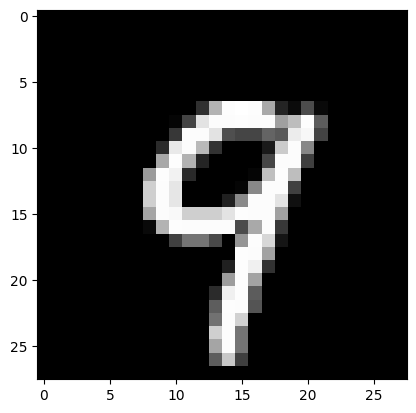

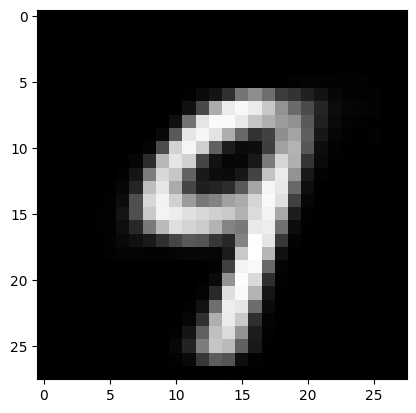

In [ ]:
# Set the model to evaluation mode
model.eval()

# Choose an index for the test sample you want to use
sample_index = 12 # Replace this with the index of the sample you want to use

input_tensor = next(iter(test_loader))
input_tensor = input_tensor[0][sample_index, 0, :, :]

plt.imshow(input_tensor, cmap='gray')
plt.show()
# Flatten and convert the input tensor to the appropriate format
flat_input = input_tensor.view(1, 1, -1).to(dtype=torch.float32)

# Pass the input through the model to get the output
with torch.no_grad():  # Use no_grad to disable gradient computation for inference
    res = model(flat_input)

# Assuming res is a 1D tensor with 784 elements
res = res.view(1, 28, 28)  # Reshape to a 28x28 tensor
res_img = res.cpu().numpy()  # Convert the tensor to a NumPy array for display
plt.imshow(res_img[0], cmap='gray')
plt.show()

# Remove Noise

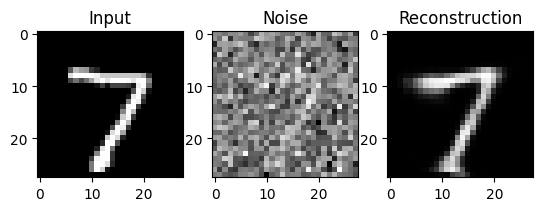

In [ ]:
def add_noise(input_image):
  noise_size = input_image.size()
  noise = torch.randn(noise_size)
  noisy_image = input_image + noise
  return noisy_image

sample_index = 0
input_tensor = next(iter(test_loader))
input_tensor = input_tensor[0][sample_index, 0, :, :]
noisy_image = add_noise(input_tensor)
visualize_noisy_reconstruction(noisy_image, model)

# Bottleneck Interpolation

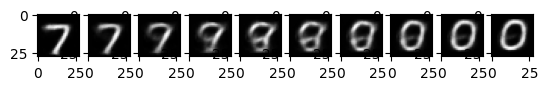

In [ ]:
def bottleneck_interpolation(image_1, image_2, n_interpolation):

  model.eval()

  with torch.no_grad():
    image_1 = image_1.view(28 * 28).to(dtype=torch.float32)
    bottleneck_1 = model.encode(image_1)
    bottleneck_1.view(-1)
    image_2 = image_2.view(28 * 28).to(dtype=torch.float32)
    bottleneck_2 = model.encode(image_2)
    bottleneck_2.view(-1)
    # print(image_1)

  fig = plt.figure()
  with torch.no_grad():
    for i in range(n_interpolation):
      interpolated_bottleneck = bottleneck_1 + (i / n_interpolation) * (bottleneck_2 - bottleneck_1)
      # print(interpolated_bottleneck)
      res = model.decode(interpolated_bottleneck)

      # Assuming res is a 1D tensor with 784 elements
      res = res.view(1, 28, 28)  # Reshape to a 28x28 tensor
      res_img = res.cpu().numpy()

      ax = plt.subplot(1, n_interpolation, i+1)
      plt.imshow(res_img[0], cmap='gray')
      # ax.set_title('Reconstruction')
  plt.show()

sample_index_1 = 0
sample_index_2 = 10
n_interpolation = 10

input_tensor = next(iter(test_loader))
image_1 = input_tensor[0][sample_index_1, 0, :, :]
image_2 = input_tensor[0][sample_index_2, 0, :, :]
image_1.size()
bottleneck_interpolation(image_1, image_2, n_interpolation)